In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

In [2]:
# Nicer plotting
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = (8,4)

# Simple Impact-T Run

In [3]:
from impact import Impact, template_dir

import matplotlib.pyplot as plt
import os

In [4]:
ifile = os.path.join(template_dir,'lcls_injector/ImpactT.in')
os.path.exists(ifile)

True

In [5]:
# Make Impact object
I = Impact(ifile, verbose=True)

================ Impact-T Summary ================
1 bunchtotal charge: 249.99999999999997 pC
Distribution type: read
Cathode start at z = 0 m
   emission time: 1.4e-11 s
   image charges neglected after z = 0.02 m
Tracking 10000 particles
Processor domain: 1 x 1 = 1 CPUs
Computational domain: 0.015 m x 0.015 m x 45.0 m
Space charge grid: 16 x 16 x 16
Maximum time steps: 1000000
Random Seed: 6
Reference Frequency: 2856000000.0 Hz
Initial reference time: 0.0 s
Simulation starting from the beginning


Configured to run in: /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpk8e1latq


In [6]:
# Change some things
I.input['header']['Np'] = 10000
I.input['header']['Nx'] = 16
I.input['header']['Ny'] = 16
I.input['header']['Nz'] = 16
I.input['header']['Dt'] = 5e-13

# Other switches
I.timeout = 1000
# Switches for MPI
I.use_mpi=True
I.input['header']['Nprow'] = 1
I.input['header']['Npcol'] = 4
I.impact_bin = '$IMPACTT_MPI_BIN'
assert os.path.exists(os.path.expandvars(I.impact_bin))

In [7]:
# Change stop location
I.ele['stop_1']['s'] = 0.1
#I.ele['stop_1']['s'] = I.ele['OTR2']['s']+.001

In [8]:
I.run()

Running Impact-T in /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpk8e1latq
Loaded fort 30 : Fourth root of the fourth moments of the beam distribution
Loaded fort 25 : RMS Y information
Loaded fort 24 : RMS X information
Loaded fort 26 : RMS Z information
Loaded fort 28 : Load balance and loss diagnostics
Loaded fort 29 : Cube root of third moments of the beam distribution
Loaded fort 18 : Time and energy
Loaded fort 27 : Max amplitude information
Loaded fort 70 : Slice information of the final distribution
Loaded fort 60 : Slice information of the initial distribution
Loading particles
Loaded fort 40 : initial particle distribution at t = 0
Loaded fort 50 : final particle distribution projected to the centroid location of the bunch
Converted initial_particles to ParticleGroup
Converted final_particles to ParticleGroup
Loading particles
Loaded fort 40 : initial particle distribution at t = 0
Loaded fort 50 : final particle distribution projected to the centroid location of the bu

In [9]:
I.input.keys()

dict_keys(['original_input', 'input_particle_file', 'header', 'lattice', 'fieldmaps'])

In [10]:
I.output.keys()

dict_keys(['run_info', 'stats', 'slice_info', 'particles'])

In [11]:
I.output['stats'].keys()

dict_keys(['t', 'mean_z', 'moment4_x', 'moment4_y', 'moment4_z', 'mean_y', 'sigma_y', 'norm_emit_y', 'mean_x', 'sigma_x', 'norm_emit_x', 'sigma_z', 'norm_emit_z', 'loadbalance_min_n_particle', 'loadbalance_max_n_particle', 'n_particle', 'moment3_x', 'moment3_y', 'moment3_z', 'mean_gamma', 'mean_beta', 'max_r', 'sigma_gamma', 'max_amplitude_x', 'max_amplitude_y', 'max_amplitude_z', 'moment4_px', 'moment4_py', 'moment4_pz', 'mean_py', 'sigma_py', 'cov_y__py', 'mean_px', 'sigma_px', 'cov_x__px', 'mean_pz', 'sigma_pz', 'cov_z__pz', 'moment3_px', 'moment3_py', 'moment3_pz', 'mean_kinetic_energy', 'max_amplitude_px', 'max_amplitude_py', 'max_amplitude_pz'])

In [12]:
I.output['slice_info'].keys()

dict_keys(['final_particle_slices', 'initial_particle_slices'])

# Particles

In [13]:
# Particles are automatically parsed in to openpmd-beamphysics ParticleGroup objects
I.output['particles']

{'initial_particles': <pmd_beamphysics.particles.ParticleGroup at 0x10a5223d0>,
 'final_particles': <pmd_beamphysics.particles.ParticleGroup at 0x113d3ba10>}

In [14]:
# Get the final particles, calculate some statistic
P = I.output['particles']['final_particles']
P['mean_energy']

5928965.86851633

In [15]:
# Show the units
P.units('mean_energy')

pmd_unit('eV', 1.602176634e-19, (2, 1, -2, 0, 0, 0, 0))

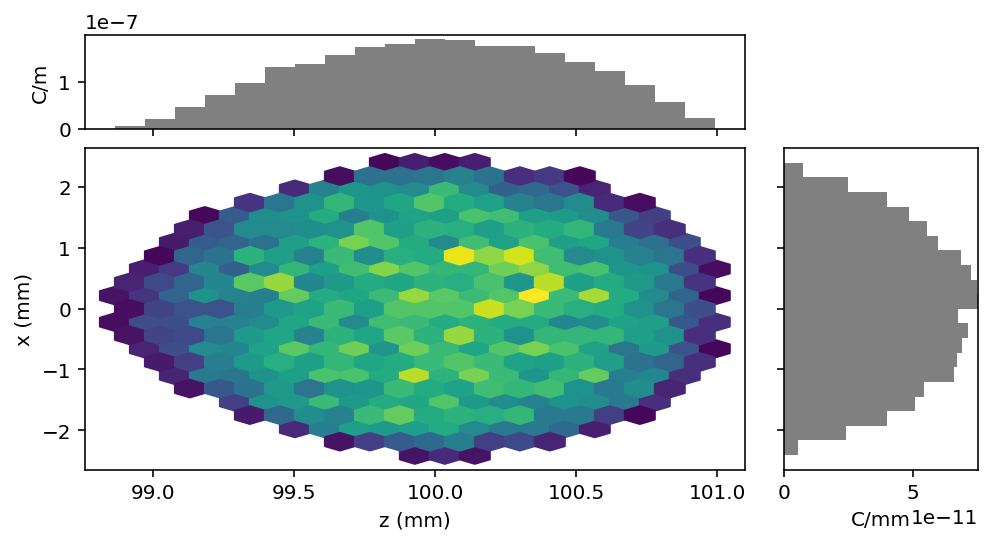

In [16]:
# This provides easy ploting
from pmd_beamphysics.plot import marginal_plot

marginal_plot(P, 'z', 'x', bins=20)

# Stats

In [17]:
# Impact's own calculated statistics can be retieved
len(I.stat('norm_emit_x')), I.stat('norm_emit_x')[-1]

(219, 4.9456523e-05)

In [18]:
# Stats can also be computed from the particles. For example:


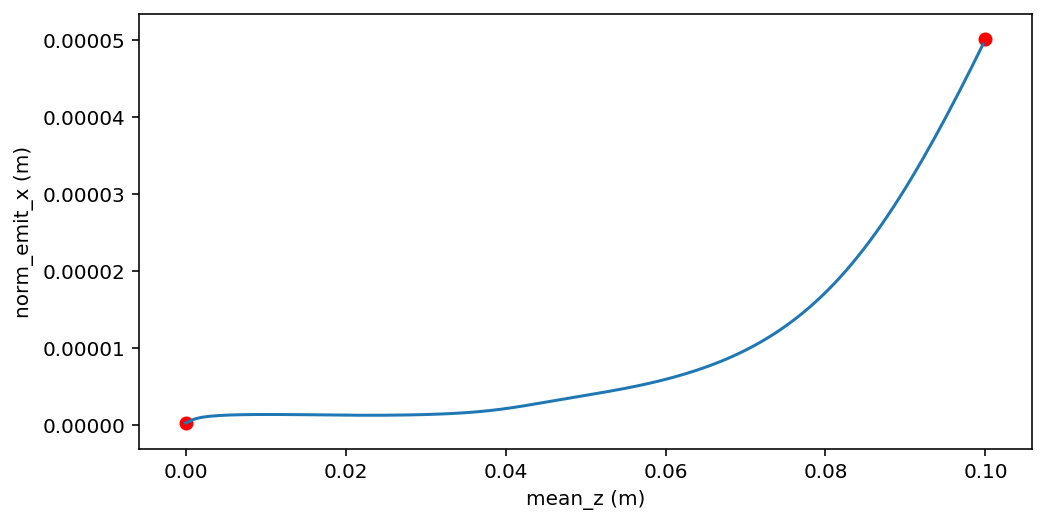

In [19]:
# Compare these. 
key1 = 'mean_z'
key2 = 'norm_emit_x'
units1 = str(I.units(key1))
units2 = str(I.units(key2))
plt.xlabel(key1+f' ({units1})')
plt.ylabel(key2+f' ({units2})')
plt.plot(I.stat(key1), I.stat(key2))
plt.scatter(
    [I.particles[name][key1] for name in I.particles], 
    [I.particles[name][key2] for name in I.particles], color='red')

# Layout

In [20]:
from bokeh.plotting import output_notebook
from bokeh.plotting import show
output_notebook(hide_banner=True)

from impact.plotting import layout_plot

In [21]:
# Change somethone
I.ele['QE01']['b1_gradient'] = 0
layout = layout_plot(I.input['lattice'], plot_height=300)
show(layout)

# Archive all output

All of .input and .output can be archived and loaded from standard h5 files.

Particles are stored in the openPMD-beamphysics format.

In [22]:
# Call the archive function. If no name is given, a name will be invented based on the fingerprint.
afile = I.archive()

Archiving to file impact_1d81ec8884ac17a300f4f78e0c8a5050.h5


In [23]:
# This can be loaded into an empty model
I2 = Impact()
I2.load_archive(afile)

Reading archive file impact_1d81ec8884ac17a300f4f78e0c8a5050.h5
h5 read: input_particle_file
h5 read fieldmaps: ['rfdata102', 'rfdata201', 'rfdata4', 'rfdata5', 'rfdata6', 'rfdata7']
reading stats
reading slice_info
Loaded from archive. Note: Must reconfigure to run again.
================ Impact-T Summary ================
1 bunchtotal charge: 249.99999999999997 pC
Distribution type: read
Cathode start at z = 0 m
   emission time: 1.4e-11 s
   image charges neglected after z = 0.02 m
Tracking 10000 particles
Processor domain: 1 x 4 = 4 CPUs
Computational domain: 0.015 m x 0.015 m x 45.0 m
Space charge grid: 16 x 16 x 16
Maximum time steps: 1000000
Random Seed: 6
Reference Frequency: 2856000000.0 Hz
Initial reference time: 0.0 s
Simulation starting from the beginning


Configured to run in: /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpihr3itnj


In [24]:
# Look at a stat, and compare with the original object
I.stat('norm_emit_x')[-1], I2.stat('norm_emit_x')[-1]

(4.9456523e-05, 4.9456523e-05)

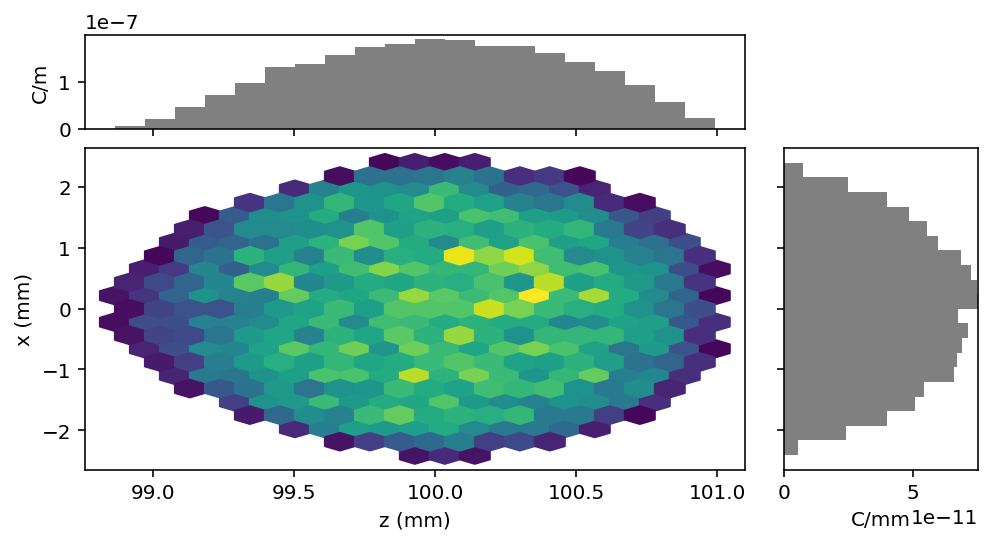

In [25]:
# The particles look the same
marginal_plot(I2.particles['final_particles'], 'z', 'x', bins=20)